#### 使用的是coco数据集 -> 需要转换成 voc数据集?

## 简介
[YOLOv3](https://arxiv.org/abs/1804.02767) 是由 [Joseph Redmon](https://arxiv.org/search/cs?searchtype=author&query=Redmon%2C+J) 和 [Ali Farhadi](https://arxiv.org/search/cs?searchtype=author&query=Farhadi%2C+A) 提出的单阶段检测器, 该检测器与达到同样精度的传统目标检测方法相比，推断速度能达到接近两倍.

## 模型结构

YOLOv3将输入图像分成S\*S个格子，每个格子预测B个bounding box，每个bounding box预测内容包括: Location(x, y, w, h)、Confidence Score和C个类别的概率，因此YOLOv3输出层的channel数为B\*(5 + C)。YOLOv3的loss函数也有三部分组成：Location误差，Confidence误差和分类误差。

YOLOv3 的网络结构由基础特征提取网络、multi-scale特征融合层和输出层组成。

1. 特征提取网络。YOLOv3使用 [DarkNet53](https://arxiv.org/abs/1612.08242)作为特征提取网络：DarkNet53 基本采用了全卷积网络，用步长为2的卷积操作替代了池化层，同时添加了 Residual 单元，避免在网络层数过深时发生梯度弥散。

2. 特征融合层。为了解决之前YOLO版本对小目标不敏感的问题，YOLOv3采用了3个不同尺度的特征图来进行目标检测，分别为13\*13,26\*26,52\*52,用来检测大、中、小三种目标。特征融合层选取 DarkNet 产出的三种尺度特征图作为输入，借鉴了FPN(feature pyramid networks)的思想，通过一系列的卷积层和上采样对各尺度的特征图进行融合。

3. 输出层。同样使用了全卷积结构，其中最后一个卷积层的卷积核个数是255：3\*(80+4+1)=255，3表示一个grid cell包含3个bounding box，4表示框的4个坐标信息，1表示Confidence Score，80表示COCO数据集中80个类别的概率。如果换用别的数据集，80可以更改为实际类别数量

- 论文链接：https://arxiv.org/pdf/1804.02767v1.pdf

本项目代码需要使用GPU环境来运行:

<img src="https://ai-studio-static-online.cdn.bcebos.com/767f625548714f03b105b6ccb3aa78df9080e38d329e445380f505ddec6c7042" width="40%" height="40%">

<br>

<br>

并且检查相关参数设置, 例如use_gpu, fluid.CUDAPlace(0)等处是否设置正确. 

### 解压螺丝螺母训练数据
背景非常干净小巧的目标检测数据集。
里面仅仅包含螺丝和螺母两种类别的目标，背景为干净的培养皿。图片数量约420张，train.txt 文件描述每个图片中的目标，label_list 文件描述类别

另附一个验证集合，有10张图片，eval.txt 描述图片中目标，格式和 train.txt 相同

In [ ]:
!ls

In [ ]:
# 解压螺丝螺母数据，并将数据处理成需要的格式
!cd data/data6045/ && unzip -qo lslm.zip && unzip -qo lslm-test.zip
!cd data/data6045/ && mv lslm/*.txt .  # 移除所有 .txt 文件
!cd data/data6045/ && mv lslm-test/*.txt . # 移除所有 .txt 文件
!cd data/data6045/ && sed -i 's/^/lslm\//' train.txt  # 
# train.txt 表明了各种训练的数据: 训练数据集,各种参数:width,height,.....
# lslm.zip 里面包含 .jpg train.txt label.txt
!cd data/data6045/ && sed -i 's/^/lslm-test\//' eval.txt
# lslm.zip 包含 .jpg eval.txt 
# eval.txt 同 train.txt
!cd data/data6045/ && awk '{print $2}' label_list.txt > label_list # 生成 label_list 文件

 查看代码,是怎么利用数据集的

In [ ]:
!ls
!cd data/data6045/ && pwd

### 训练配置
训练YOLOv3模型的配置项，配置里控制以下行为：
- 可以控制是否启用tiny版本，tiny版本体积小，适合部署在移动设备。本次实验默认使用 tiny
- 训练轮数
- 每批次训练图片数量
- 是否使用GPU训练
- 学习率调整
- 训练图片尺寸 & anchors 的尺寸

如果不熟悉，请不要随便更改训练图片的尺寸和anchors的尺寸，两者相互关联

In [26]:
# -*- coding: UTF-8 -*-
"""
训练常基于dark-net的YOLOv3网络，目标检测
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import os
os.environ["FLAGS_fraction_of_gpu_memory_to_use"] = '0.82'
import uuid
import numpy as np
import time
import six
import math
import random
import paddle
import paddle.fluid as fluid
import logging
import xml.etree.ElementTree
import codecs
import json

from paddle.fluid.initializer import MSRA
from paddle.fluid.param_attr import ParamAttr
from paddle.fluid.regularizer import L2Decay
from PIL import Image, ImageEnhance, ImageDraw

logger = None
train_parameters = { 
    "data_dir": "data/data6045/lslm",# 训练数据集文件夹
    "train_list": "train.txt",
    "eval_list": "eval.txt",
    "class_dim": -1, # 类别数量 ,后面会变
    "label_dict": {},
    "num_dict": {},
    "image_count": -1,
    "continue_train": True,     # 是否加载前一次的训练参数，接着训练
    "pretrained": False,
    "pretrained_model_dir": "./pretrained-model",
    "save_model_dir": "./yolo-model",
    "model_prefix": "yolo-v3",
    "freeze_dir": "freeze_model",
    "use_tiny": True,          # 是否使用 裁剪 tiny 模型
    "max_box_num": 20,          # 一幅图上最多有多少个目标
    "num_epochs": 20, # 运行的轮数
    "train_batch_size": 32,      # 对于完整 yolov3，每一批的训练样本不能太多，内存会炸掉；如果使用 tiny，可以适当大一些
    "use_gpu": True,
    "yolo_cfg": {
        "input_size": [3, 448, 448],    # 原版的边长大小为608，为了提高训练速度和预测速度，此处压缩为448
        "anchors": [7, 10, 12, 22, 24, 17, 22, 45, 46, 33, 43, 88, 85, 66, 115, 146, 275, 240],
        "anchor_mask": [[6, 7, 8], [3, 4, 5], [0, 1, 2]]
    },
    "yolo_tiny_cfg": {
        "input_size": [3, 256, 256],
        "anchors": [6, 8, 13, 15, 22, 34, 48, 50, 81, 100, 205, 191],
        "anchor_mask": [[3, 4, 5], [0, 1, 2]]
    },
    "ignore_thresh": 0.7,
    "mean_rgb": [127.5, 127.5, 127.5],
    "mode": "train",
    "multi_data_reader_count": 4,
    "apply_distort": True,
    "nms_top_k": 300,
    "nms_pos_k": 300,
    "valid_thresh": 0.01,
    "nms_thresh": 0.45,
    "image_distort_strategy": {
        "expand_prob": 0.5,
        "expand_max_ratio": 4,
        "hue_prob": 0.5,
        "hue_delta": 18,
        "contrast_prob": 0.5,
        "contrast_delta": 0.5,
        "saturation_prob": 0.5,
        "saturation_delta": 0.5,
        "brightness_prob": 0.5,
        "brightness_delta": 0.125
    },
    "sgd_strategy": {
        "learning_rate": 0.002,
        "lr_epochs": [30, 50, 65],
        "lr_decay": [1, 0.5, 0.25, 0.1]
    },
    "early_stop": {
        "sample_frequency": 50,
        "successive_limit": 3,
        "min_loss": 2.5,
        "min_curr_map": 0.84
    }
}


def init_train_parameters():
    """
    初始化训练参数，主要是初始化图片数量，类别数
    :return:
    """
    file_list = os.path.join(train_parameters['data_dir'], train_parameters['train_list'])
    label_list = os.path.join(train_parameters['data_dir'], "label_list")
    index = 0
    with codecs.open(label_list, encoding='utf-8') as flist:
        lines = [line.strip() for line in flist]
        for line in lines:
            train_parameters['num_dict'][index] = line.strip()
            train_parameters['label_dict'][line.strip()] = index
            index += 1
        train_parameters['class_dim'] = index
    with codecs.open(file_list, encoding='utf-8') as flist:
        lines = [line.strip() for line in flist]
        train_parameters['image_count'] = len(lines)

### 日志相关的配置

In [13]:
def init_log_config():
    """
    初始化日志相关配置
    :return:
    """
    global logger
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    log_path = os.path.join(os.getcwd(), 'logs')
    if not os.path.exists(log_path):
        os.makedirs(log_path)
    log_name = os.path.join(log_path, 'train.log')
    fh = logging.FileHandler(log_name, mode='w')
    fh.setLevel(logging.DEBUG)
    formatter = logging.Formatter("%(asctime)s - %(filename)s[line:%(lineno)d] - %(levelname)s: %(message)s")
    fh.setFormatter(formatter)
    logger.addHandler(fh)
    
    
init_log_config()

### YOLOv3网络结构
- YOLOv3网络结构
- YOLOv3-tiny网络结构

根据配置使用不同的模型

In [14]:
class YOLOv3(object):
    def __init__(self, class_num, anchors, anchor_mask):
        self.outputs = []
        self.downsample_ratio = 1
        self.anchor_mask = anchor_mask
        self.anchors = anchors
        self.class_num = class_num

        self.yolo_anchors = []
        self.yolo_classes = []
        for mask_pair in self.anchor_mask:
            mask_anchors = []
            for mask in mask_pair:
                mask_anchors.append(self.anchors[2 * mask])
                mask_anchors.append(self.anchors[2 * mask + 1])
            self.yolo_anchors.append(mask_anchors)
            self.yolo_classes.append(class_num)

    def name(self):
        return 'YOLOv3'

    def get_anchors(self):
        return self.anchors

    def get_anchor_mask(self):
        return self.anchor_mask

    def get_class_num(self):
        return self.class_num

    def get_downsample_ratio(self):
        return self.downsample_ratio

    def get_yolo_anchors(self):
        return self.yolo_anchors

    def get_yolo_classes(self):
        return self.yolo_classes

    def conv_bn(self,
                input,
                num_filters,
                filter_size,
                stride,
                padding,
                use_cudnn=True):
        conv = fluid.layers.conv2d(
            input=input,
            num_filters=num_filters,
            filter_size=filter_size,
            stride=stride,
            padding=padding,
            act=None,
            use_cudnn=use_cudnn,
            param_attr=ParamAttr(initializer=fluid.initializer.Normal(0., 0.02)),
            bias_attr=False)

        # batch_norm中的参数不需要参与正则化，所以主动使用正则系数为0的正则项屏蔽掉
        # 在batch_norm中使用 leaky 的话，只能使用默认的 alpha=0.02；如果需要设值，必须提出去单独来
        out = fluid.layers.batch_norm(
            input=conv, act=None, 
            param_attr=ParamAttr(initializer=fluid.initializer.Normal(0., 0.02), regularizer=L2Decay(0.)),
            bias_attr=ParamAttr(initializer=fluid.initializer.Constant(0.0), regularizer=L2Decay(0.)))
        out = fluid.layers.leaky_relu(out, 0.1)
        return out

    def downsample(self, input, num_filters, filter_size=3, stride=2, padding=1):
        self.downsample_ratio *= 2
        return self.conv_bn(input, 
                num_filters=num_filters, 
                filter_size=filter_size, 
                stride=stride, 
                padding=padding)

    def basicblock(self, input, num_filters):
        conv1 = self.conv_bn(input, num_filters, filter_size=1, stride=1, padding=0)
        conv2 = self.conv_bn(conv1, num_filters * 2, filter_size=3, stride=1, padding=1)
        out = fluid.layers.elementwise_add(x=input, y=conv2, act=None)
        return out

    def layer_warp(self, input, num_filters, count):
        res_out = self.basicblock(input, num_filters)
        for j in range(1, count):
            res_out = self.basicblock(res_out, num_filters)
        return res_out

    def upsample(self, input, scale=2):
        # get dynamic upsample output shape
        shape_nchw = fluid.layers.shape(input)
        shape_hw = fluid.layers.slice(shape_nchw, axes=[0], starts=[2], ends=[4])
        shape_hw.stop_gradient = True
        in_shape = fluid.layers.cast(shape_hw, dtype='int32')
        out_shape = in_shape * scale
        out_shape.stop_gradient = True

        # reisze by actual_shape
        out = fluid.layers.resize_nearest(
            input=input,
            scale=scale,
            actual_shape=out_shape)
        return out
    
    def yolo_detection_block(self, input, num_filters):
        assert num_filters % 2 == 0, "num_filters {} cannot be divided by 2".format(num_filters)
        conv = input
        for j in range(2):
            conv = self.conv_bn(conv, num_filters, filter_size=1, stride=1, padding=0)
            conv = self.conv_bn(conv, num_filters * 2, filter_size=3, stride=1, padding=1)
        route = self.conv_bn(conv, num_filters, filter_size=1, stride=1, padding=0)
        tip = self.conv_bn(route, num_filters * 2, filter_size=3, stride=1, padding=1)
        return route, tip

    def net(self, img): 
        # darknet
        stages = [1,2,8,8,4]
        assert len(self.anchor_mask) <= len(stages), "anchor masks can't bigger than downsample times"
        # 256x256
        conv1 = self.conv_bn(img, num_filters=32, filter_size=3, stride=1, padding=1)
        downsample_  = self.downsample(conv1, conv1.shape[1] * 2)
        blocks = []

        for i, stage_count in enumerate(stages):
            block = self.layer_warp(downsample_, 32 *(2**i), stage_count)
            blocks.append(block)
            if i < len(stages) - 1:
                downsample_ = self.downsample(block, block.shape[1]*2)
        blocks = blocks[-1:-4:-1]   # 取倒数三层，并且逆序，后面跨层级联需要

        # yolo detector
        for i, block in enumerate(blocks):
            # yolo 中跨视域链接
            if i > 0:
                block = fluid.layers.concat(input=[route, block], axis=1)
            route, tip = self.yolo_detection_block(block, num_filters=512 // (2**i))
            block_out = fluid.layers.conv2d(
                input=tip,
                num_filters=len(self.anchor_mask[i]) * (self.class_num + 5),      # 5 elements represent x|y|h|w|score
                filter_size=1,
                stride=1,
                padding=0,
                act=None,
                param_attr=ParamAttr(initializer=fluid.initializer.Normal(0., 0.02)),
                bias_attr=ParamAttr(initializer=fluid.initializer.Constant(0.0), regularizer=L2Decay(0.)))
            self.outputs.append(block_out)
            # 为了跨视域链接，差值方式提升特征图尺寸
            if i < len(blocks) - 1:
                route = self.conv_bn(route, 256//(2**i), filter_size=1, stride=1, padding=0)
                route = self.upsample(route)

        return self.outputs


class YOLOv3Tiny(object):
    def __init__(self, class_num, anchors, anchor_mask):
        self.outputs = []
        self.downsample_ratio = 1
        self.anchor_mask = anchor_mask
        self.anchors = anchors
        self.class_num = class_num

        self.yolo_anchors = []
        self.yolo_classes = []
        for mask_pair in self.anchor_mask:
            mask_anchors = []
            for mask in mask_pair:
                mask_anchors.append(self.anchors[2 * mask])
                mask_anchors.append(self.anchors[2 * mask + 1])
            self.yolo_anchors.append(mask_anchors)
            self.yolo_classes.append(class_num)

    def name(self):
        return 'YOLOv3-tiny'

    def get_anchors(self):
        return self.anchors

    def get_anchor_mask(self):
        return self.anchor_mask

    def get_class_num(self):
        return self.class_num

    def get_downsample_ratio(self):
        return self.downsample_ratio

    def get_yolo_anchors(self):
        return self.yolo_anchors

    def get_yolo_classes(self):
        return self.yolo_classes

    def conv_bn(self,
                input,
                num_filters,
                filter_size,
                stride,
                padding,
                num_groups=1,
                use_cudnn=True):
        conv = fluid.layers.conv2d(
            input=input,
            num_filters=num_filters,
            filter_size=filter_size,
            stride=stride,
            padding=padding,
            act=None,
            groups=num_groups,
            use_cudnn=use_cudnn,
            param_attr=ParamAttr(initializer=fluid.initializer.Normal(0., 0.02)),
            bias_attr=False)

        # batch_norm中的参数不需要参与正则化，所以主动使用正则系数为0的正则项屏蔽掉
        out = fluid.layers.batch_norm(
            input=conv, act='relu', 
            param_attr=ParamAttr(initializer=fluid.initializer.Normal(0., 0.02), regularizer=L2Decay(0.)),
            bias_attr=ParamAttr(initializer=fluid.initializer.Constant(0.0), regularizer=L2Decay(0.)))

        return out

    def depthwise_conv_bn(self, input, filter_size=3, stride=1, padding=1):
        num_filters = input.shape[1]
        return self.conv_bn(input, 
                num_filters=num_filters, 
                filter_size=filter_size, 
                stride=stride, 
                padding=padding, 
                num_groups=num_filters)

    def downsample(self, input, pool_size=2, pool_stride=2):
        self.downsample_ratio *= 2
        return fluid.layers.pool2d(input=input, pool_type='max', pool_size=pool_size,
                                    pool_stride=pool_stride)

    def basicblock(self, input, num_filters):
        conv1 = self.conv_bn(input, num_filters, filter_size=3, stride=1, padding=1)
        out = self.downsample(conv1)
        return out


    def upsample(self, input, scale=2):
        # get dynamic upsample output shape
        shape_nchw = fluid.layers.shape(input)
        shape_hw = fluid.layers.slice(shape_nchw, axes=[0], starts=[2], ends=[4])
        shape_hw.stop_gradient = True
        in_shape = fluid.layers.cast(shape_hw, dtype='int32')
        out_shape = in_shape * scale
        out_shape.stop_gradient = True

        # reisze by actual_shape
        out = fluid.layers.resize_nearest(
            input=input,
            scale=scale,
            actual_shape=out_shape)
        return out
    
    def yolo_detection_block(self, input, num_filters):
        route = self.conv_bn(input, num_filters, filter_size=1, stride=1, padding=0)
        tip = self.conv_bn(route, num_filters * 2, filter_size=3, stride=1, padding=1)
        return route, tip

    def net(self, img): 
        # darknet-tiny
        stages = [16, 32, 64, 128, 256, 512]
        assert len(self.anchor_mask) <= len(stages), "anchor masks can't bigger than downsample times"
        # 256x256
        tmp = img
        blocks = []
        for i, stage_count in enumerate(stages):
            if i == len(stages) - 1:
                block = self.conv_bn(tmp, stage_count, filter_size=3, stride=1, padding=1)
                blocks.append(block)
                block = self.depthwise_conv_bn(blocks[-1])
                block = self.depthwise_conv_bn(blocks[-1])
                block = self.conv_bn(blocks[-1], stage_count * 2, filter_size=1, stride=1, padding=0)
                blocks.append(block)
            else:
                tmp = self.basicblock(tmp, stage_count)
                blocks.append(tmp)
        
        blocks = [blocks[-1], blocks[3]]

        # yolo detector
        for i, block in enumerate(blocks):
            # yolo 中跨视域链接
            if i > 0:
                block = fluid.layers.concat(input=[route, block], axis=1)
            if i < 1:
                route, tip = self.yolo_detection_block(block, num_filters=256 // (2**i))
            else:
                tip = self.conv_bn(block, num_filters=256, filter_size=3, stride=1, padding=1)
            block_out = fluid.layers.conv2d(
                input=tip,
                num_filters=len(self.anchor_mask[i]) * (self.class_num + 5),      # 5 elements represent x|y|h|w|score
                filter_size=1,
                stride=1,
                padding=0,
                act=None,
                param_attr=ParamAttr(initializer=fluid.initializer.Normal(0., 0.02)),
                bias_attr=ParamAttr(initializer=fluid.initializer.Constant(0.0), regularizer=L2Decay(0.)))
            self.outputs.append(block_out)
            # 为了跨视域链接，差值方式提升特征图尺寸
            if i < len(blocks) - 1:
                route = self.conv_bn(route, 128 // (2**i), filter_size=1, stride=1, padding=0)
                route = self.upsample(route)

        return self.outputs
        

def get_yolo(is_tiny, class_num, anchors, anchor_mask):
    if is_tiny:
        return YOLOv3Tiny(class_num, anchors, anchor_mask)
    else:
        return YOLOv3(class_num, anchors, anchor_mask)

### 定义训练时候，数据增强需要的辅助类，例如外接矩形框

In [15]:
class Sampler(object):
    """
    采样器，用于扣取采样
    """

    def __init__(self, max_sample, max_trial, min_scale, max_scale,
                 min_aspect_ratio, max_aspect_ratio, min_jaccard_overlap,
                 max_jaccard_overlap):
        """
        构造函数
        :param max_sample:
        :param max_trial:
        :param min_scale:
        :param max_scale:
        :param min_aspect_ratio:
        :param max_aspect_ratio:
        :param min_jaccard_overlap:
        :param max_jaccard_overlap:
        """
        self.max_sample = max_sample
        self.max_trial = max_trial
        self.min_scale = min_scale
        self.max_scale = max_scale
        self.min_aspect_ratio = min_aspect_ratio
        self.max_aspect_ratio = max_aspect_ratio
        self.min_jaccard_overlap = min_jaccard_overlap
        self.max_jaccard_overlap = max_jaccard_overlap


class bbox(object):
    """
    外界矩形框
    """

    def __init__(self, xmin, ymin, xmax, ymax):
        """
        构造函数
        :param xmin:
        :param ymin:
        :param xmax:
        :param ymax:
        """
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax

### 训练数据增强，主要是采样。利用随机截取训练图上的框来生成新的训练样本。同时要保证采样的样本能包含真实的目标。采样之后，为了保持训练数据格式的一致性，还需要对标注的坐标信息做变换

In [16]:
def box_to_center_relative(box, img_height, img_width):
    """
    Convert COCO annotations box with format [x1, y1, w, h] to 
    center mode [center_x, center_y, w, h] and divide image width
    and height to get relative value in range[0, 1]
    """
    assert len(box) == 4, "box should be a len(4) list or tuple"
    x, y, w, h = box

    x1 = max(x, 0)
    x2 = min(x + w - 1, img_width - 1)
    y1 = max(y, 0)
    y2 = min(y + h - 1, img_height - 1)

    x = (x1 + x2) / 2 / img_width
    y = (y1 + y2) / 2 / img_height
    w = (x2 - x1) / img_width
    h = (y2 - y1) / img_height

    return np.array([x, y, w, h])


def resize_img(img, sampled_labels, input_size):
    target_size = input_size
    img = img.resize((target_size[1], target_size[2]), Image.BILINEAR)
    return img


def box_iou_xywh(box1, box2):
    assert box1.shape[-1] == 4, "Box1 shape[-1] should be 4."
    assert box2.shape[-1] == 4, "Box2 shape[-1] should be 4."

    b1_x1, b1_x2 = box1[:, 0] - box1[:, 2] / 2, box1[:, 0] + box1[:, 2] / 2
    b1_y1, b1_y2 = box1[:, 1] - box1[:, 3] / 2, box1[:, 1] + box1[:, 3] / 2
    b2_x1, b2_x2 = box2[:, 0] - box2[:, 2] / 2, box2[:, 0] + box2[:, 2] / 2
    b2_y1, b2_y2 = box2[:, 1] - box2[:, 3] / 2, box2[:, 1] + box2[:, 3] / 2

    inter_x1 = np.maximum(b1_x1, b2_x1)
    inter_x2 = np.minimum(b1_x2, b2_x2)
    inter_y1 = np.maximum(b1_y1, b2_y1)
    inter_y2 = np.minimum(b1_y2, b2_y2)
    inter_w = inter_x2 - inter_x1 + 1
    inter_h = inter_y2 - inter_y1 + 1
    inter_w[inter_w < 0] = 0
    inter_h[inter_h < 0] = 0

    inter_area = inter_w * inter_h
    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

    return inter_area / (b1_area + b2_area - inter_area)


def box_crop(boxes, labels, crop, img_shape):
    x, y, w, h = map(float, crop)
    im_w, im_h = map(float, img_shape)

    boxes = boxes.copy()
    boxes[:, 0], boxes[:, 2] = (boxes[:, 0] - boxes[:, 2] / 2) * im_w, (boxes[:, 0] + boxes[:, 2] / 2) * im_w
    boxes[:, 1], boxes[:, 3] = (boxes[:, 1] - boxes[:, 3] / 2) * im_h, (boxes[:, 1] + boxes[:, 3] / 2) * im_h

    crop_box = np.array([x, y, x + w, y + h])
    centers = (boxes[:, :2] + boxes[:, 2:]) / 2.0
    mask = np.logical_and(crop_box[:2] <= centers, centers <= crop_box[2:]).all(axis=1)

    boxes[:, :2] = np.maximum(boxes[:, :2], crop_box[:2])
    boxes[:, 2:] = np.minimum(boxes[:, 2:], crop_box[2:])
    boxes[:, :2] -= crop_box[:2]
    boxes[:, 2:] -= crop_box[:2]

    mask = np.logical_and(mask, (boxes[:, :2] < boxes[:, 2:]).all(axis=1))
    boxes = boxes * np.expand_dims(mask.astype('float32'), axis=1)
    labels = labels * mask.astype('float32')
    boxes[:, 0], boxes[:, 2] = (boxes[:, 0] + boxes[:, 2]) / 2 / w, (boxes[:, 2] - boxes[:, 0]) / w
    boxes[:, 1], boxes[:, 3] = (boxes[:, 1] + boxes[:, 3]) / 2 / h, (boxes[:, 3] - boxes[:, 1]) / h

    return boxes, labels, mask.sum()

### 图像增强相关的函数：
- 对比度
- 饱和度
- 明暗
- 颜色
- 扩张

In [17]:
def random_brightness(img):
    prob = np.random.uniform(0, 1)
    if prob < train_parameters['image_distort_strategy']['brightness_prob']:
        brightness_delta = train_parameters['image_distort_strategy']['brightness_delta']
        delta = np.random.uniform(-brightness_delta, brightness_delta) + 1
        img = ImageEnhance.Brightness(img).enhance(delta)
    return img


def random_contrast(img):
    prob = np.random.uniform(0, 1)
    if prob < train_parameters['image_distort_strategy']['contrast_prob']:
        contrast_delta = train_parameters['image_distort_strategy']['contrast_delta']
        delta = np.random.uniform(-contrast_delta, contrast_delta) + 1
        img = ImageEnhance.Contrast(img).enhance(delta)
    return img


def random_saturation(img):
    prob = np.random.uniform(0, 1)
    if prob < train_parameters['image_distort_strategy']['saturation_prob']:
        saturation_delta = train_parameters['image_distort_strategy']['saturation_delta']
        delta = np.random.uniform(-saturation_delta, saturation_delta) + 1
        img = ImageEnhance.Color(img).enhance(delta)
    return img


def random_hue(img):
    prob = np.random.uniform(0, 1)
    if prob < train_parameters['image_distort_strategy']['hue_prob']:
        hue_delta = train_parameters['image_distort_strategy']['hue_delta']
        delta = np.random.uniform(-hue_delta, hue_delta)
        img_hsv = np.array(img.convert('HSV'))
        img_hsv[:, :, 0] = img_hsv[:, :, 0] + delta
        img = Image.fromarray(img_hsv, mode='HSV').convert('RGB')
    return img


def distort_image(img):
    prob = np.random.uniform(0, 1)
    # Apply different distort order
    if prob > 0.5:
        img = random_brightness(img)
        img = random_contrast(img)
        img = random_saturation(img)
        img = random_hue(img)
    else:
        img = random_brightness(img)
        img = random_saturation(img)
        img = random_hue(img)
        img = random_contrast(img)
    return img


def random_crop(img, boxes, labels, scales=[0.3, 1.0], max_ratio=2.0, constraints=None, max_trial=50):
    if random.random() > 0.6:
        return img, boxes, labels
    if len(boxes) == 0:
        return img, boxes, labels

    if not constraints:
        constraints = [
                (0.1, 1.0),
                (0.3, 1.0),
                (0.5, 1.0),
                (0.7, 1.0),
                (0.9, 1.0),
                (0.0, 1.0)]

    w, h = img.size
    crops = [(0, 0, w, h)]
    for min_iou, max_iou in constraints:
        for _ in range(max_trial):
            scale = random.uniform(scales[0], scales[1])
            aspect_ratio = random.uniform(max(1 / max_ratio, scale * scale), \
                                          min(max_ratio, 1 / scale / scale))
            crop_h = int(h * scale / np.sqrt(aspect_ratio))
            crop_w = int(w * scale * np.sqrt(aspect_ratio))
            crop_x = random.randrange(w - crop_w)
            crop_y = random.randrange(h - crop_h)
            crop_box = np.array([[
                (crop_x + crop_w / 2.0) / w,
                (crop_y + crop_h / 2.0) / h,
                crop_w / float(w),
                crop_h /float(h)
                ]])

            iou = box_iou_xywh(crop_box, boxes)
            if min_iou <= iou.min() and max_iou >= iou.max():
                crops.append((crop_x, crop_y, crop_w, crop_h))
                break

    while crops:
        crop = crops.pop(np.random.randint(0, len(crops)))
        crop_boxes, crop_labels, box_num = box_crop(boxes, labels, crop, (w, h))
        if box_num < 1:
            continue
        img = img.crop((crop[0], crop[1], crop[0] + crop[2], 
                        crop[1] + crop[3])).resize(img.size, Image.LANCZOS)
        return img, crop_boxes, crop_labels
    return img, boxes, labels


def random_expand(img, gtboxes, keep_ratio=True):
    if np.random.uniform(0, 1) < train_parameters['image_distort_strategy']['expand_prob']:
        return img, gtboxes

    max_ratio = train_parameters['image_distort_strategy']['expand_max_ratio']    
    w, h = img.size
    c = 3
    ratio_x = random.uniform(1, max_ratio)
    if keep_ratio:
        ratio_y = ratio_x
    else:
        ratio_y = random.uniform(1, max_ratio)
    oh = int(h * ratio_y)
    ow = int(w * ratio_x)
    off_x = random.randint(0, ow -w)
    off_y = random.randint(0, oh -h)

    out_img = np.zeros((oh, ow, c), np.uint8)
    for i in range(c):
        out_img[:, :, i] = train_parameters['mean_rgb'][i]

    out_img[off_y: off_y + h, off_x: off_x + w, :] = img
    gtboxes[:, 0] = ((gtboxes[:, 0] * w) + off_x) / float(ow)
    gtboxes[:, 1] = ((gtboxes[:, 1] * h) + off_y) / float(oh)
    gtboxes[:, 2] = gtboxes[:, 2] / ratio_x
    gtboxes[:, 3] = gtboxes[:, 3] / ratio_y

    return Image.fromarray(out_img), gtboxes


def preprocess(img, bbox_labels, input_size, mode):
    img_width, img_height = img.size
    sample_labels = np.array(bbox_labels)
    if mode == 'train':
        if train_parameters['apply_distort']:
            img = distort_image(img)
        img, gtboxes = random_expand(img, sample_labels[:, 1:5])
        img, gtboxes, gtlabels = random_crop(img, gtboxes, sample_labels[:, 0])
        sample_labels[:, 0] = gtlabels
        sample_labels[:, 1:5] = gtboxes
    img = resize_img(img, sample_labels, input_size)
    img = np.array(img).astype('float32')
    img -= train_parameters['mean_rgb']
    img = img.transpose((2, 0, 1))  # HWC to CHW
    img *= 0.007843
    return img, sample_labels

### 数据读取器
自定义数据读取器，如果需要自定义数据，需要修改下面这段函数，以适配自定义数据的格式

此外还定义了训练时候的读取方式，有同步的读取器，也有异步的读取器

In [18]:
def custom_reader(file_list, data_dir, input_size, mode):
    def reader():
        np.random.shuffle(file_list)
        for line in file_list:
            if mode == 'train' or mode == 'eval':
                ######################  以下可能是需要自定义修改的部分   ############################
                parts = line.split('\t')
                image_path = parts[0]
                img = Image.open(os.path.join(data_dir, image_path))
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                im_width, im_height = img.size
                # bbox 的列表，每一个元素为这样
                # layout: label | x-center | y-cneter | width | height | difficult
                bbox_labels = []
                for object_str in parts[1:]:
                    if len(object_str) <= 1:
                        continue
                    bbox_sample = []
                    object = json.loads(object_str)
                    bbox_sample.append(float(train_parameters['label_dict'][object['value']]))
                    bbox = object['coordinate']
                    box = [bbox[0][0], bbox[0][1], bbox[1][0] - bbox[0][0], bbox[1][1] - bbox[0][1]]
                    bbox = box_to_center_relative(box, im_height, im_width)
                    bbox_sample.append(float(bbox[0]))
                    bbox_sample.append(float(bbox[1]))
                    bbox_sample.append(float(bbox[2]))
                    bbox_sample.append(float(bbox[3]))
                    difficult = float(0)
                    bbox_sample.append(difficult)
                    bbox_labels.append(bbox_sample)
                ######################  可能需要自定义修改部分结束   ############################
                if len(bbox_labels) == 0: continue
                img, sample_labels = preprocess(img, bbox_labels, input_size, mode)
                # sample_labels = np.array(sample_labels)
                if len(sample_labels) == 0: continue
                boxes = sample_labels[:, 1:5]
                lbls = sample_labels[:, 0].astype('int32')
                difficults = sample_labels[:, -1].astype('int32')
                max_box_num = train_parameters['max_box_num']
                cope_size = max_box_num if len(boxes) >= max_box_num else len(boxes)
                ret_boxes = np.zeros((max_box_num, 4), dtype=np.float32)
                ret_lbls = np.zeros((max_box_num), dtype=np.int32)
                ret_difficults = np.zeros((max_box_num), dtype=np.int32)
                ret_boxes[0: cope_size] = boxes[0: cope_size]
                ret_lbls[0: cope_size] = lbls[0: cope_size]
                ret_difficults[0: cope_size] = difficults[0: cope_size]
                yield img, ret_boxes, ret_lbls
            elif mode == 'test':
                img_path = os.path.join(line)
                yield Image.open(img_path)

    return reader


### 定义优化器
- 定义同步数据读取
- 定义优化器
- 构建 program 和损失函数

注意yolo_loss里面，smooth_label 选项默认为 True，如果类别较少的情况下，建议置为 False

In [19]:
def single_custom_reader(file_path, data_dir, input_size, mode):
    file_path = os.path.join(data_dir, file_path)
    images = [line.strip() for line in open(file_path)]
    reader = custom_reader(images, data_dir, input_size, mode)
    reader = paddle.reader.shuffle(reader, train_parameters['train_batch_size'])
    reader = paddle.batch(reader, train_parameters['train_batch_size'])
    return reader


def optimizer_sgd_setting():
    batch_size = train_parameters["train_batch_size"]
    iters = train_parameters["image_count"] // batch_size
    iters = 1 if iters < 1 else iters
    learning_strategy = train_parameters['sgd_strategy']
    lr = learning_strategy['learning_rate']

    boundaries = [i * iters for i in learning_strategy["lr_epochs"]]
    values = [i * lr for i in learning_strategy["lr_decay"]]
    logger.info("origin learning rate: {0} boundaries: {1}  values: {2}".format(lr, boundaries, values))

    optimizer = fluid.optimizer.SGDOptimizer(
        learning_rate=fluid.layers.piecewise_decay(boundaries, values),
        # learning_rate=lr,
        regularization=fluid.regularizer.L2Decay(0.00005))

    return optimizer


def build_program_with_feeder(main_prog, startup_prog, place):
    max_box_num = train_parameters['max_box_num']
    ues_tiny = train_parameters['use_tiny']
    yolo_config = train_parameters['yolo_tiny_cfg'] if ues_tiny else train_parameters['yolo_cfg']
    with fluid.program_guard(main_prog, startup_prog):
        img = fluid.layers.data(name='img', shape=yolo_config['input_size'], dtype='float32')
        gt_box = fluid.layers.data(name='gt_box', shape=[max_box_num, 4], dtype='float32')
        gt_label = fluid.layers.data(name='gt_label', shape=[max_box_num], dtype='int32')
        feeder = fluid.DataFeeder(feed_list=[img, gt_box, gt_label], place=place, program=main_prog)
        reader = single_custom_reader(train_parameters['train_list'],
                                    train_parameters['data_dir'],
                                    yolo_config['input_size'], 'train')
        ues_tiny = train_parameters['use_tiny']
        yolo_config = train_parameters['yolo_tiny_cfg'] if ues_tiny else train_parameters['yolo_cfg']
        with fluid.unique_name.guard():
            model = get_yolo(ues_tiny, train_parameters['class_dim'], yolo_config['anchors'], yolo_config['anchor_mask'])
            outputs = model.net(img)
        return feeder, reader, get_loss(model, outputs, gt_box, gt_label)
        

def get_loss(model, outputs, gt_box, gt_label):
    losses = []
    downsample_ratio = model.get_downsample_ratio()
    with fluid.unique_name.guard('train'):
        for i, out in enumerate(outputs):
            loss = fluid.layers.yolov3_loss(
                x=out,
                gt_box=gt_box,
                gt_label=gt_label,
                anchors=model.get_anchors(),
                anchor_mask=model.get_anchor_mask()[i],
                class_num=model.get_class_num(),
                ignore_thresh=train_parameters['ignore_thresh'],
                use_label_smooth=False,  # 对于类别不多的情况，设置为 False 会更合适一些，不然 score 会很小
                downsample_ratio=downsample_ratio)
            losses.append(fluid.layers.reduce_mean(loss))
            downsample_ratio //= 2
        loss = sum(losses)
        optimizer = optimizer_sgd_setting()
        optimizer.minimize(loss)
        return loss

### 加载已经有的参数

In [20]:
def load_pretrained_params(exe, program):
    if train_parameters['continue_train'] and os.path.exists(train_parameters['save_model_dir']):
        logger.info('load param from retrain model')
        fluid.io.load_persistables(executor=exe,
                                   dirname=train_parameters['save_model_dir'],
                                   main_program=program)
    elif train_parameters['pretrained'] and os.path.exists(train_parameters['pretrained_model_dir']):
        logger.info('load param from pretrained model')
        def if_exist(var):
            return os.path.exists(os.path.join(train_parameters['pretrained_model_dir'], var.name))

        fluid.io.load_vars(exe, train_parameters['pretrained_model_dir'], main_program=program,
                           predicate=if_exist)

### 训练主体，开始愉快的炼丹吧~
当前日志默认输出到日志文件中，刷新左侧文件显示，能看到在 logs 目录下。可以在编辑区上方【终端】里输入如下命令看到滚动的日志
```
tailf logs/train.log
```
为了演示，此处并没有训练很多轮，如果需要得到较好的效果，可以增加训练轮数

In [27]:
!pwd

/d/Desktop/big_innovate/code


In [30]:
def train():
    init_log_config()
    init_train_parameters()
    logger.info("start train YOLOv3, train params:%s", str(train_parameters))

    logger.info("create place, use gpu:" + str(train_parameters['use_gpu']))
    place = fluid.CUDAPlace(0) if train_parameters['use_gpu'] else fluid.CPUPlace()

    logger.info("build network and program")
    train_program = fluid.Program()
    start_program = fluid.Program()
    feeder, reader, loss = build_program_with_feeder(train_program, start_program, place)

    logger.info("build executor and init params")
    exe = fluid.Executor(place)
    exe.run(start_program)
    train_fetch_list = [loss.name]
    load_pretrained_params(exe, train_program)

    stop_strategy = train_parameters['early_stop']
    successive_limit = stop_strategy['successive_limit']
    sample_freq = stop_strategy['sample_frequency']
    min_curr_map = stop_strategy['min_curr_map']
    min_loss = stop_strategy['min_loss']
    stop_train = False
    successive_count = 0
    total_batch_count = 0
    valid_thresh = train_parameters['valid_thresh']
    nms_thresh = train_parameters['nms_thresh']
    current_best_loss = 10000000000.0
    for pass_id in range(train_parameters["num_epochs"]):
        logger.info("current pass: {}, start read image".format(pass_id))
        print("current pass: {}, start read image".format(pass_id))
        batch_id = 0
        total_loss = 0.0
        for batch_id, data in enumerate(reader()):
            t1 = time.time()
            loss = exe.run(train_program, feed=feeder.feed(data), fetch_list=train_fetch_list)
            period = time.time() - t1
            loss = np.mean(np.array(loss))
            total_loss += loss
            batch_id += 1
            total_batch_count += 1

            if batch_id % 3 == 0:      # 调整日志输出的频率
                logger.info("pass {}, trainbatch {}, loss {} time {}".format(pass_id, batch_id, loss, "%2.2f sec" % period))
                print("pass {}, trainbatch {}, loss {} time {}".format(pass_id, batch_id, loss, "%2.2f sec" % period))

        pass_mean_loss = total_loss / batch_id
        logger.info("pass {0} train result, current pass mean loss: {1}".format(pass_id, pass_mean_loss))
        print("pass {0} train result, current pass mean loss: {1}".format(pass_id, pass_mean_loss))
        # 采用每训练完一轮停止办法，可以调整为更精细的保存策略
        if pass_mean_loss < current_best_loss:
            logger.info("temp save {} epcho train result, current best pass loss {}".format(pass_id, pass_mean_loss))
            print("temp save {} epcho train result, current best pass loss {}".format(pass_id, pass_mean_loss))
            # print something
            fluid.io.save_persistables(dirname=train_parameters['save_model_dir'], main_program=train_program, executor=exe)
            current_best_loss = pass_mean_loss

    logger.info("training till last epcho, end training")
    fluid.io.save_persistables(dirname=train_parameters['save_model_dir'], main_program=train_program, executor=exe)


if __name__ == '__main__':
    paddle.enable_static()# use static grapg mode
    train()

current pass: 0, start read image
pass 0, trainbatch 3, loss 89.4629135131836 time 0.25 sec
pass 0, trainbatch 6, loss 92.91592407226562 time 0.25 sec
pass 0, trainbatch 9, loss 84.40426635742188 time 0.29 sec
pass 0, trainbatch 12, loss 75.73065185546875 time 0.26 sec
pass 0 train result, current pass mean loss: 87.21730569692758
temp save 0 epcho train result, current best pass loss 87.21730569692758
current pass: 1, start read image
pass 1, trainbatch 3, loss 81.36617279052734 time 0.25 sec
pass 1, trainbatch 6, loss 72.5244140625 time 0.26 sec
pass 1, trainbatch 9, loss 68.17637634277344 time 0.26 sec
pass 1, trainbatch 12, loss 66.51241302490234 time 0.26 sec
pass 1 train result, current pass mean loss: 72.19341688889723
temp save 1 epcho train result, current best pass loss 72.19341688889723
current pass: 2, start read image
pass 2, trainbatch 3, loss 70.63267517089844 time 0.27 sec
pass 2, trainbatch 6, loss 63.6498908996582 time 0.26 sec
pass 2, trainbatch 9, loss 68.0407257080

KeyboardInterrupt: 

### 固化保存模型

In [31]:
import paddle
import paddle.fluid as fluid
import codecs

init_train_parameters()

def freeze_model():

    exe = fluid.Executor(fluid.CPUPlace())
    ues_tiny = train_parameters['use_tiny']
    yolo_config = train_parameters['yolo_tiny_cfg'] if ues_tiny else train_parameters['yolo_cfg']
    path = train_parameters['save_model_dir']
    model = get_yolo(ues_tiny, train_parameters['class_dim'], yolo_config['anchors'], yolo_config['anchor_mask'])
    image = fluid.layers.data(name='image', shape=yolo_config['input_size'], dtype='float32')
    image_shape = fluid.layers.data(name="image_shape", shape=[2], dtype='int32')

    boxes = []
    scores = []
    outputs = model.net(image)
    downsample_ratio = model.get_downsample_ratio()
    for i, out in enumerate(outputs):
        box, score = fluid.layers.yolo_box(
            x=out,
            img_size=image_shape,
            anchors=model.get_yolo_anchors()[i],
            class_num=model.get_class_num(),
            conf_thresh=train_parameters['valid_thresh'],
            downsample_ratio=downsample_ratio,
            name="yolo_box_" + str(i))
        boxes.append(box)
        scores.append(fluid.layers.transpose(score, perm=[0, 2, 1]))
        downsample_ratio //= 2

    pred = fluid.layers.multiclass_nms(
        bboxes=fluid.layers.concat(boxes, axis=1),
        scores=fluid.layers.concat(scores, axis=2),
        score_threshold=train_parameters['valid_thresh'],
        nms_top_k=train_parameters['nms_top_k'],
        keep_top_k=train_parameters['nms_pos_k'],
        nms_threshold=train_parameters['nms_thresh'],
        background_label=-1,
        name="multiclass_nms")

    freeze_program = fluid.default_main_program()
    fluid.io.load_persistables(exe, path, freeze_program)
    freeze_program = freeze_program.clone(for_test=True)
    print("freeze out: {0}, pred layout: {1}".format(train_parameters['freeze_dir'], pred))
    fluid.io.save_inference_model(train_parameters['freeze_dir'], ['image', 'image_shape'], pred, exe, freeze_program)
    print("freeze end")


if __name__ == '__main__':
    freeze_model()

freeze out: freeze_model, pred layout: var multiclass_nms.tmp_0 : LOD_TENSOR.shape(960, 6).dtype(float32).stop_gradient(True)
freeze end


### 加载固化的模型进行预测

label_dict:{0: 'bolt', 1: 'nut'} class dim:2
predict cost time:0.19 sec


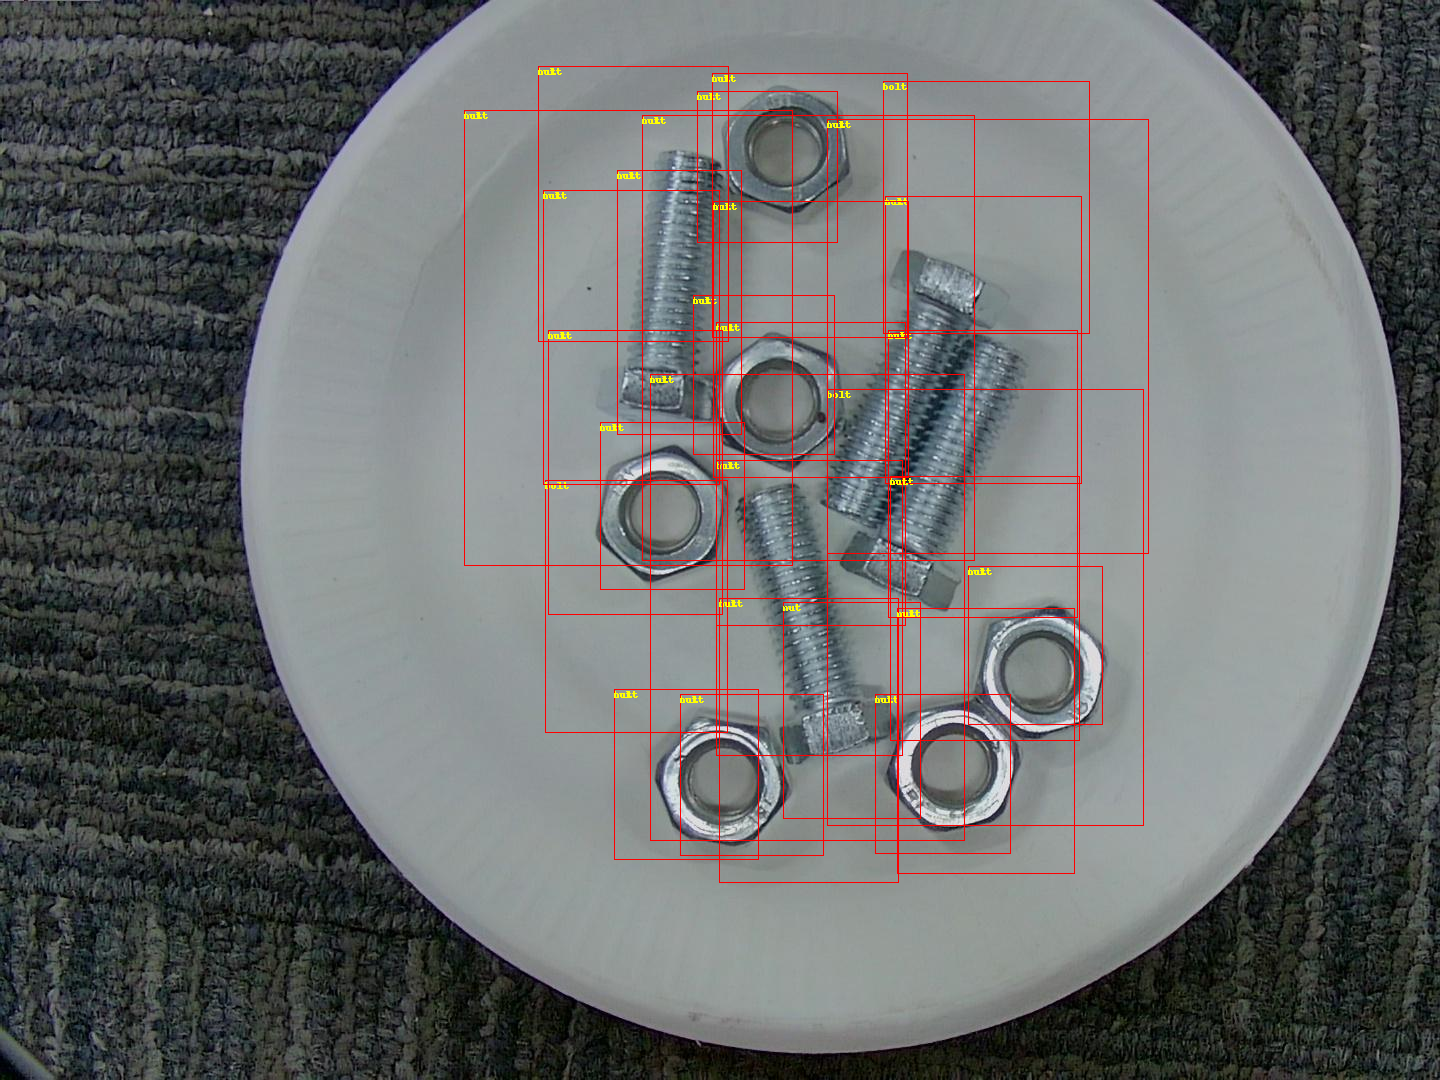

In [33]:
import codecs
import sys
import numpy as np
import time
import paddle
import paddle.fluid as fluid
import math
import functools

from IPython.display import display
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
from collections import namedtuple


init_train_parameters()
ues_tiny = train_parameters['use_tiny']
yolo_config = train_parameters['yolo_tiny_cfg'] if ues_tiny else train_parameters['yolo_cfg']

target_size = yolo_config['input_size']
anchors = yolo_config['anchors']
anchor_mask = yolo_config['anchor_mask']
label_dict = train_parameters['num_dict']
class_dim = train_parameters['class_dim']
print("label_dict:{} class dim:{}".format(label_dict, class_dim))
place = fluid.CUDAPlace(0) if train_parameters['use_gpu'] else fluid.CPUPlace()
exe = fluid.Executor(place)
path = train_parameters['freeze_dir']
[inference_program, feed_target_names, fetch_targets] = fluid.io.load_inference_model(dirname=path, executor=exe)


def draw_bbox_image(img, boxes, labels, save_name):
    """
    给图片画上外接矩形框
    :param img:
    :param boxes:
    :param save_name:
    :param labels
    :return:
    """

    img_width, img_height = img.size
    draw = ImageDraw.Draw(img)
    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box[0], box[1], box[2], box[3]
        draw.rectangle((xmin, ymin, xmax, ymax), None, 'red')
        draw.text((xmin, ymin), label_dict[int(label)], (255, 255, 0))
    img.save(save_name)
    display(img)


def resize_img(img, target_size):
    """
    保持比例的缩放图片
    :param img:
    :param target_size:
    :return:
    """
    img = img.resize(target_size[1:], Image.BILINEAR)
    return img


def read_image(img_path):
    """
    读取图片
    :param img_path:
    :return:
    """
    origin = Image.open(img_path)
    img = resize_img(origin, target_size)
    resized_img = img.copy()
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = np.array(img).astype('float32').transpose((2, 0, 1))  # HWC to CHW
    img -= 127.5
    img *= 0.007843
    img = img[np.newaxis, :]
    return origin, img, resized_img


def infer(image_path):
    """
    预测，将结果保存到一副新的图片中
    :param image_path:
    :return:
    """
    origin, tensor_img, resized_img = read_image(image_path)
    input_w, input_h = origin.size[0], origin.size[1]
    image_shape = np.array([input_h, input_w], dtype='int32')
    # print("image shape high:{0}, width:{1}".format(input_h, input_w))
    t1 = time.time()
    batch_outputs = exe.run(inference_program,
                            feed={feed_target_names[0]: tensor_img,
                                  feed_target_names[1]: image_shape[np.newaxis, :]},
                            fetch_list=fetch_targets,
                            return_numpy=False)
    period = time.time() - t1
    print("predict cost time:{0}".format("%2.2f sec" % period))
    bboxes = np.array(batch_outputs[0])
    # print(bboxes)

    if bboxes.shape[1] != 6:
        print("No object found in {}".format(image_path))
        return
    labels = bboxes[:, 0].astype('int32')
    scores = bboxes[:, 1].astype('float32')
    boxes = bboxes[:, 2:].astype('float32')

    last_dot_index = image_path.rfind('.')
    out_path = image_path[:last_dot_index]
    out_path += '-result.jpg'
    draw_bbox_image(origin, boxes, labels, out_path)


if __name__ == '__main__':
    image_name = sys.argv[1]
    image_path = image_name
    image_path = "data/data6045/lslm-test/3.jpg"
    infer(image_path)

In [ ]:
!tar -cf yolo-model.tar yolo-model/*